## Part 2. Predicting Weekly Total Resolution Time by Request Type
In this section, we aim to predict the weekly total resolution time to provide actionable workload estimates that can support more effective crew scheduling and resource planning. The process involves aggregating service request data at the weekly level, performing targeted feature engineering to capture temporal and contextual patterns, and training predictive models to estimate the total hours required for resolution by request type and neighborhood. To evaluate model effectiveness, we also compare performance against a baseline approach that relies on historical averages, enabling us to quantify the value added by machine learning techniques.

### 1. Import Packages and Load Data

In [42]:
# import packages needed
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error,root_mean_squared_error
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [43]:
# Load the dataset
data = pd.read_csv('../data/DPW_data_r3y.csv')
data.head()

,_id,group_id,num_requests,parent_closed,status_name,status_code,dept,request_type_name,request_type_id,create_date_et,create_date_utc,last_action_et,last_action_utc,closed_date_et,closed_date_utc,origin,street,cross_street,street_id,cross_street_id,city,neighborhood,census_tract,council_district,ward,police_zone,latitude,longitude,geo_accuracy,date
0,1,827262,1,f,open,0,DPW - Administration,Park Shelter,543,2024-03-12 10:50:00,2024-03-12T14:50:00,2024-03-12 10:50:00,2024-03-12T14:50:00,NaN,NaN,Call Center,NaN,NaN,NaN,NaN,Pittsburgh,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NULL_COORDINATES,2024-03-12
1,2,720661,1,f,open,0,DPW - Administration,Park Shelter,543,2023-03-20 07:52:00,2023-03-20T11:52:00,2023-03-20 07:52:00,2023-03-20T11:52:00,NaN,NaN,Call Center,NaN,NaN,NaN,NaN,Pittsburgh,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NULL_COORDINATES,2023-03-20
2,3,722010,1,f,open,0,DPW - Administration,Park Shelter,543,2023-03-24 07:44:00,2023-03-24T11:44:00,2023-03-24 07:44:00,2023-03-24T11:44:00,NaN,NaN,Call Center,NaN,NaN,NaN,NaN,Pittsburgh,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NULL_COORDINATES,2023-03-24
3,4,846915,1,f,open,0,Police - Zones 1-6,Illegal Parking,417,2024-05-19 12:24:00,2024-05-19T16:24:00,2024-05-19 12:24:00,2024-05-19T16:24:00,NaN,NaN,Website,NaN,NaN,NaN,NaN,Pittsburgh,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NULL_COORDINATES,2024-05-19
4,5,853708,1,f,open,0,DPW - Facilities,City Facility,375,2024-06-06 23:04:00,2024-06-07T03:04:00,2024-06-06 23:04:00,2024-06-07T03:04:00,NaN,NaN,Website,NaN,NaN,NaN,NaN,Pittsburgh,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NULL_COORDINATES,2024-06-06


In [44]:
# Filter the dataset for DPW - Street Maintenance
dpw_sm = data[data['dept'] == 'DPW - Street Maintenance']
dpw_sm.head()

,_id,group_id,num_requests,parent_closed,status_name,status_code,dept,request_type_name,request_type_id,create_date_et,create_date_utc,last_action_et,last_action_utc,closed_date_et,closed_date_utc,origin,street,cross_street,street_id,cross_street_id,city,neighborhood,census_tract,council_district,ward,police_zone,latitude,longitude,geo_accuracy,date
55,65,755693,1,f,in progress,3,DPW - Street Maintenance,"Litter, Public Property",831,2023-07-08 11:38:00,2023-07-08T15:38:00,2023-07-10 11:31:00,2023-07-10T15:31:00,NaN,NaN,Website,NaN,NaN,NaN,NaN,Pittsburgh,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NULL_COORDINATES,2023-07-08
74,86,880597,1,t,closed,1,DPW - Street Maintenance,Trail Maintenance,541,2024-08-28 08:23:00,2024-08-28T12:23:00,2024-12-26 12:45:00,2024-12-26T17:45:00,2024-12-26T12:45:00,2024-12-26T17:45:00,Call Center,NaN,NaN,NaN,NaN,Pittsburgh,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NULL_COORDINATES,2024-08-28
147,177,882900,1,t,closed,1,DPW - Street Maintenance,Street Cleaning/Sweeping,317,2024-09-05 09:41:00,2024-09-05T13:41:00,2024-09-27 06:35:00,2024-09-27T10:35:00,2024-09-27T06:35:00,2024-09-27T10:35:00,Call Center,NaN,NaN,NaN,NaN,Pittsburgh,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NULL_COORDINATES,2024-09-05
380,454,873480,1,t,closed,1,DPW - Street Maintenance,Trail Maintenance,541,2024-08-06 11:35:00,2024-08-06T15:35:00,2024-12-26 12:51:00,2024-12-26T17:51:00,2024-12-26T12:51:00,2024-12-26T17:51:00,Call Center,NaN,NaN,NaN,NaN,Pittsburgh,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NULL_COORDINATES,2024-08-06
560,669,738943,1,f,open,0,DPW - Street Maintenance,"Litter, Public Property",831,2023-05-22 10:12:00,2023-05-22T14:12:00,2023-05-22 10:12:00,2023-05-22T14:12:00,NaN,NaN,Website,NaN,NaN,0.0,0.0,Pittsburgh,NaN,4.200398e+10,6.0,NaN,NaN,40.446306,-80.027041,EXACT,2023-05-22


In [45]:
# Check duplicated data
dups = dpw_sm.duplicated()
dups.any()

np.False_

### 2. Filter by Status

 - Analyze the distribution of request statuses.
 - Select only requests that have been marked as 'closed' as these have a defined resolution time.


In [46]:
# Check the count and percentage of status_name = 'closed' requests
status_counts = dpw_sm['status_name'].value_counts()
print(status_counts)
closed_pct = status_counts['closed'] / status_counts.sum()
print(f"Percentage of 'closed': {closed_pct:.2%}")


status_name
closed         37111
in progress     1187
open             782
on hold           10
Name: count, dtype: int64
Percentage of 'closed': 94.94%


In [47]:
# Select only 'closed' requests for modeling resolution time
sm_closed = dpw_sm[dpw_sm['status_name'] == 'closed'].copy()
sm_closed.shape[0]

37111

In [48]:
# Display columns of the closed requests dataframe
sm_closed.columns

Index(['_id', 'group_id', 'num_requests', 'parent_closed', 'status_name',
       'status_code', 'dept', 'request_type_name', 'request_type_id',
       'create_date_et', 'create_date_utc', 'last_action_et',
       'last_action_utc', 'closed_date_et', 'closed_date_utc', 'origin',
       'street', 'cross_street', 'street_id', 'cross_street_id', 'city',
       'neighborhood', 'census_tract', 'council_district', 'ward',
       'police_zone', 'latitude', 'longitude', 'geo_accuracy', 'date'],
      dtype='object')

### 3. Calculate Resolution Time (Target Variable)

 - Convert `create_date_et` and `closed_date_et` columns to datetime objects.
 - Calculate the `resolution_time_hr` as the difference between closed and create dates in hours.
 - Check for any null values created during datetime conversion.

In [49]:
# Check the data types of the columns
print(sm_closed['create_date_et'].dtype, sm_closed['closed_date_et'].dtype)

# Parse columns to datetime
sm_closed['create_date'] = pd.to_datetime(sm_closed['create_date_et'], errors='coerce')
sm_closed['closed_date'] = pd.to_datetime(sm_closed['closed_date_et'], errors='coerce')
print(sm_closed[['create_date', 'closed_date']].isnull().sum())


object object
create_date    0
closed_date    0
dtype: int64


In [50]:
# Calculate resolution time in hours
sm_closed['resolution_time_hr'] = (sm_closed['closed_date'] - sm_closed['create_date']).dt.total_seconds() / 3600
sm_closed.head()

,_id,group_id,num_requests,parent_closed,status_name,status_code,dept,request_type_name,request_type_id,create_date_et,create_date_utc,last_action_et,last_action_utc,closed_date_et,closed_date_utc,origin,street,cross_street,street_id,cross_street_id,city,neighborhood,census_tract,council_district,ward,police_zone,latitude,longitude,geo_accuracy,date,create_date,closed_date,resolution_time_hr
74,86,880597,1,t,closed,1,DPW - Street Maintenance,Trail Maintenance,541,2024-08-28 08:23:00,2024-08-28T12:23:00,2024-12-26 12:45:00,2024-12-26T17:45:00,2024-12-26T12:45:00,2024-12-26T17:45:00,Call Center,NaN,NaN,NaN,NaN,Pittsburgh,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NULL_COORDINATES,2024-08-28,2024-08-28 08:23:00,2024-12-26 12:45:00,2884.366667
147,177,882900,1,t,closed,1,DPW - Street Maintenance,Street Cleaning/Sweeping,317,2024-09-05 09:41:00,2024-09-05T13:41:00,2024-09-27 06:35:00,2024-09-27T10:35:00,2024-09-27T06:35:00,2024-09-27T10:35:00,Call Center,NaN,NaN,NaN,NaN,Pittsburgh,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NULL_COORDINATES,2024-09-05,2024-09-05 09:41:00,2024-09-27 06:35:00,524.900000
380,454,873480,1,t,closed,1,DPW - Street Maintenance,Trail Maintenance,541,2024-08-06 11:35:00,2024-08-06T15:35:00,2024-12-26 12:51:00,2024-12-26T17:51:00,2024-12-26T12:51:00,2024-12-26T17:51:00,Call Center,NaN,NaN,NaN,NaN,Pittsburgh,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NULL_COORDINATES,2024-08-06,2024-08-06 11:35:00,2024-12-26 12:51:00,3409.266667
853,1023,885954,1,t,closed,1,DPW - Street Maintenance,Street Obstruction/Closure,26739,2024-09-16 11:37:00,2024-09-16T15:37:00,2024-09-25 07:02:00,2024-09-25T11:02:00,2024-09-25T07:02:00,2024-09-25T11:02:00,Website,NaN,NaN,NaN,NaN,Pittsburgh,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NULL_COORDINATES,2024-09-16,2024-09-16 11:37:00,2024-09-25 07:02:00,211.416667
1031,1238,869173,1,t,closed,1,DPW - Street Maintenance,"Litter, Public Property",831,2024-07-23 16:34:00,2024-07-23T20:34:00,2024-09-25 09:36:00,2024-09-25T13:36:00,2024-09-25T09:36:00,2024-09-25T13:36:00,Website,NaN,NaN,NaN,NaN,Pittsburgh,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NULL_COORDINATES,2024-07-23,2024-07-23 16:34:00,2024-09-25 09:36:00,1529.033333


### 4. Remove Unnecessary Columns

 - Define a list of columns to be dropped. These include identifiers, redundant date/time formats, status columns (already filtered), and department (already filtered).
 - Drop the specified columns from the dataframe.

In [51]:
# Check current columns in the dataframe
sm_closed.columns

Index(['_id', 'group_id', 'num_requests', 'parent_closed', 'status_name',
       'status_code', 'dept', 'request_type_name', 'request_type_id',
       'create_date_et', 'create_date_utc', 'last_action_et',
       'last_action_utc', 'closed_date_et', 'closed_date_utc', 'origin',
       'street', 'cross_street', 'street_id', 'cross_street_id', 'city',
       'neighborhood', 'census_tract', 'council_district', 'ward',
       'police_zone', 'latitude', 'longitude', 'geo_accuracy', 'date',
       'create_date', 'closed_date', 'resolution_time_hr'],
      dtype='object')

In [52]:
# Remove unecessary data (duplicate information or filtered columns)
cols_to_drop = [
    '_id', 'parent_closed','status_name', 'status_code', 'dept', 'request_type_id',
    'create_date_et', 'create_date_utc', 'last_action_et', 'last_action_utc',
    'closed_date_et', 'closed_date_utc', 'street_id', 'cross_street_id', 'date'
]

sm_cleaned = sm_closed.drop(columns=[col for col in cols_to_drop if col in sm_closed.columns])


In [53]:
# Display remaining columns
sm_cleaned.columns

Index(['group_id', 'num_requests', 'request_type_name', 'origin', 'street',
       'cross_street', 'city', 'neighborhood', 'census_tract',
       'council_district', 'ward', 'police_zone', 'latitude', 'longitude',
       'geo_accuracy', 'create_date', 'closed_date', 'resolution_time_hr'],
      dtype='object')

### 5. Handle Missing Values & Outliers

 - Calculate and display the count and percentage of missing values for each remaining column.
 - Drop columns with a high percentage of missing values ('cross_street', 'census_tract').
 - Drop rows where any of the remaining columns have missing values (small percentages).
 - Identify and remove specific request types marked as '(DO NOT USE)'.
 - Add 'year' and 'week' columns derived from the `create_date` for temporal aggregation.


In [54]:
# Check missing values (count & percentage) for each column
missing_count = sm_cleaned.isnull().sum()
missing_pct = (sm_cleaned.isnull().mean() * 100).round(2)

missing_df = pd.DataFrame({
    'missing_count': missing_count,
    'missing_percentage': missing_pct
}).sort_values(by='missing_count', ascending=False)

# Columns with missing values > 0
missing_df[missing_df['missing_count'] > 0]

,missing_count,missing_percentage
cross_street,29210,78.71
census_tract,28432,76.61
street,490,1.32
neighborhood,288,0.78
police_zone,283,0.76
ward,269,0.72
council_district,227,0.61
latitude,170,0.46
longitude,170,0.46


In [55]:
# Drop top 2 columns with the most missing values (too sparse)
cols_to_drop = ['cross_street', 'census_tract']
sm_cleaned = sm_cleaned.drop(columns=[col for col in cols_to_drop if col in sm_cleaned.columns])


In [56]:
# Drop rows with missing values (small percentage)
sm_cleaned = sm_cleaned.dropna()
sm_cleaned.shape

(36528, 16)

In [57]:
# Identify counts with request_type_name == 'Potholes (DO NOT USE)' or 'Snow/Ice Removal (DO NOT USE)'
sm_cleaned['request_type_name'].value_counts().loc[['Potholes (DO NOT USE)', 'Snow/Ice Removal (DO NOT USE)']]

request_type_name
Potholes (DO NOT USE)            8
Snow/Ice Removal (DO NOT USE)    4
Name: count, dtype: int64

In [58]:
# Drop request types (e.g. 'Potholes (DO NOT USE)' and 'Snow/Ice Removal (DO NOT USE)')
sm_cleaned = sm_cleaned[~sm_cleaned['request_type_name'].isin(['Potholes (DO NOT USE)', 'Snow/Ice Removal (DO NOT USE)'])]
sm_cleaned.shape

(36516, 16)

In [59]:
# Display the cleaned dataframe
sm_cleaned.head()

,group_id,num_requests,request_type_name,origin,street,city,neighborhood,council_district,ward,police_zone,latitude,longitude,geo_accuracy,create_date,closed_date,resolution_time_hr
2867,651240,1,Public Right of Way,Control Panel,HIGH ST,Pittsburgh,Spring Garden,1.0,24.0,1.0,40.461200,-79.989511,EXACT,2022-06-30 14:45:00,2024-10-31 10:02:00,20491.283333
4522,623904,1,Overgrowth,Call Center,BAYTREE ST,Pittsburgh,Perry North,1.0,26.0,1.0,40.488343,-80.013614,EXACT,2022-04-13 12:23:00,2024-11-26 10:28:00,22990.083333
4688,639650,1,Overgrowth,Call Center,BOGGSTON AVE,Pittsburgh,Beltzhoover,3.0,18.0,3.0,40.418495,-80.009478,EXACT,2022-06-01 10:32:00,2025-02-28 06:26:00,24067.900000
5186,658409,1,Overgrowth,Call Center,HIGHLAND DR,Pittsburgh,Lincoln-Lemington-Belmar,9.0,12.0,5.0,40.478380,-79.899982,EXACT,2022-07-22 15:51:00,2025-03-17 13:02:00,23253.183333
6666,871974,1,Trail Maintenance,Report2Gov Website,E Ohio St,Pittsburgh,Troy Hill,1.0,24.0,1.0,40.458903,-79.985800,EXACT,2024-08-01 09:31:00,2024-09-21 12:10:00,1226.650000


In [60]:
# Add year and week columns
sm_cleaned['year'] = sm_cleaned['create_date'].dt.isocalendar().year
sm_cleaned['week'] = sm_cleaned['create_date'].dt.isocalendar().week

### 6. Train / Test Data Split       
      Train: 2022/04 ~ 2024/03   
      Test: 2024/04 ~ 2025/03   
 - Split the `sm_cleaned` dataframe into `train_data` and `test_data` based on `create_date`.
 - Aggregate both train and test data by year, week, and request type, calculating the count (`resolution_count`) and sum (`total_resolution_hr`) of resolution times for each group.


In [61]:
# Split the training and testing data based on the create_date
train_mask = (sm_cleaned['create_date'] >= '2022-04-01') & (sm_cleaned['create_date'] <= '2024-03-31')
test_mask = (sm_cleaned['create_date'] >= '2024-04-01') & (sm_cleaned['create_date'] <= '2025-03-31')
train_data = sm_cleaned[train_mask]
test_data = sm_cleaned[test_mask]
print('Size of training dataset:',len(train_data), ' | Size of testing dataset:',len(test_data))
print('Train(%) =', len(train_data) / (len(train_data) + len(test_data)) * 100)
print('Test(%) =', len(test_data) / (len(train_data) + len(test_data)) * 100)

Size of training dataset: 24538  | Size of testing dataset: 11923
Train(%) = 67.2993061078961
Test(%) = 32.70069389210389


In [62]:
train_data.columns

Index(['group_id', 'num_requests', 'request_type_name', 'origin', 'street',
       'city', 'neighborhood', 'council_district', 'ward', 'police_zone',
       'latitude', 'longitude', 'geo_accuracy', 'create_date', 'closed_date',
       'resolution_time_hr', 'year', 'week'],
      dtype='object')

In [63]:
# Aggregate training data by year, week, and request type
train_agg = train_data.groupby(['year', 'week', 'request_type_name', 'neighborhood'])['resolution_time_hr'].agg(['count', 'sum']).reset_index()
train_agg.rename(columns={'count': 'resolution_count', 'sum': 'total_resolution_hr'}, inplace=True)

# Aggregate testing data similarly
test_agg = test_data.groupby(['year', 'week', 'request_type_name', 'neighborhood'])['resolution_time_hr'].agg(['count', 'sum']).reset_index()
test_agg.rename(columns={'count': 'resolution_count', 'sum': 'total_resolution_hr'}, inplace=True)


In [64]:
train_agg.head()

,year,week,request_type_name,neighborhood,resolution_count,total_resolution_hr
0,2022,13,Drainage/Leak,Stanton Heights,1,4.766667
1,2022,13,Leaves/Street Cleaning,Squirrel Hill South,2,581.233333
2,2022,13,"Litter, Public Property",Allegheny Center,1,15.583333
3,2022,13,"Litter, Public Property",Arlington,1,457.466667
4,2022,13,"Litter, Public Property",Carrick,2,225.850000


### 7. Feature Engineering
 - Create lagged features representing the previous week's activity:
 - `last_week_resolution_count`: Number of resolved requests of the same type in the previous week.
 - `last_week_total_resolution_hr`: Total resolution hours for the same request type in the previous week.
 - Merge these lagged features back into the `train_agg` and `test_agg` dataframes based on year, week, and request type.
 - Fill any resulting NaN values (likely from the first week in the dataset) with 0.


In [65]:
# Create lagged version of train_agg
train_lag = train_agg.copy()
train_lag['week'] += 1  # shift week forward so we can join back on "last week"
train_lag.rename(columns={
    'resolution_count': 'last_week_resolution_count',
    'total_resolution_hr': 'last_week_total_resolution_hr'
}, inplace=True)

# Merge back to train_agg
train_agg = pd.merge(
    train_agg,
    train_lag[['year', 'week', 'request_type_name', 'neighborhood', 'last_week_resolution_count', 'last_week_total_resolution_hr']],
    how='left',
    on=['year', 'week', 'request_type_name', 'neighborhood']
)

# Same for test_agg
test_lag = test_agg.copy()
test_lag['week'] += 1
test_lag.rename(columns={
    'resolution_count': 'last_week_resolution_count',
    'total_resolution_hr': 'last_week_total_resolution_hr'
}, inplace=True)

test_agg = pd.merge(
    test_agg,
    test_lag[['year', 'week', 'request_type_name', 'neighborhood', 'last_week_resolution_count', 'last_week_total_resolution_hr']],
    how='left',
    on=['year', 'week', 'request_type_name', 'neighborhood']
)

In [66]:
print(train_agg.isna().sum())
print(test_agg.isna().sum())

year                                0
week                                0
request_type_name                   0
neighborhood                        0
resolution_count                    0
total_resolution_hr                 0
last_week_resolution_count       8893
last_week_total_resolution_hr    8893
dtype: int64
year                                0
week                                0
request_type_name                   0
neighborhood                        0
resolution_count                    0
total_resolution_hr                 0
last_week_resolution_count       3818
last_week_total_resolution_hr    3818
dtype: int64


In [67]:
# Fill NaN values with 0
train_agg.fillna(0, inplace=True)
test_agg.fillna(0, inplace=True)

In [68]:
# Check the final columns of the training data
train_agg.head()

,year,week,request_type_name,neighborhood,resolution_count,total_resolution_hr,last_week_resolution_count,last_week_total_resolution_hr
0,2022,13,Drainage/Leak,Stanton Heights,1,4.766667,0.0,0.0
1,2022,13,Leaves/Street Cleaning,Squirrel Hill South,2,581.233333,0.0,0.0
2,2022,13,"Litter, Public Property",Allegheny Center,1,15.583333,0.0,0.0
3,2022,13,"Litter, Public Property",Arlington,1,457.466667,0.0,0.0
4,2022,13,"Litter, Public Property",Carrick,2,225.850000,0.0,0.0


### 8. Model Training and Hyperparameter Tuning
#
 - Define features (`request_type_name`, `week`, `last_week_resolution_count`, `last_week_total_resolution_hr`) and the target variable (`total_resolution_hr`).
 - Prepare `X_train`, `y_train`, `X_test`, `y_test` from the aggregated dataframes.
 - Set up a preprocessing pipeline:
    - One-hot encode categorical features (`request_type_name`, `week`).
    - Standard scale numerical features (`last_week_resolution_count`, `last_week_total_resolution_hr`).
 - Define multiple regression models (RandomForest, LinearRegression, GradientBoosting, SVR).
 - Train each model initially with default parameters and evaluate using MAE and RMSE.
 - Define hyperparameter grids for tuning each model.
 - Use GridSearchCV with 5-fold cross-validation to find the best hyperparameters for each model based on minimizing RMSE.
 - Store the best fitted model and its performance metrics (MAE, RMSE) for each algorithm.
 - Print the evaluation results and best parameters found for each model.

#### 8.1 Initial Model Training (Default Parameters)

In [69]:
# RandomForestRegressor: MAE = 3012.46 hours, RMSE = 6582.62 hours
# LinearRegression: MAE = 3271.11 hours, RMSE = 6172.66 hours
# GradientBoostingRegressor: MAE = 3174.88 hours, RMSE = 6664.48 hours
# SVR: MAE = 3202.03 hours, RMSE = 7795.10 hours
features = ['request_type_name', 'week', 'neighborhood', 'last_week_resolution_count','last_week_total_resolution_hr']
target = 'total_resolution_hr'

# Split the data into training and testing sets
X_train = train_agg[features]
y_train = train_agg[target]
X_test = test_agg[features]
y_test = test_agg[target]

# Preprocessing + modeling pipeline
categorical = ['request_type_name', 'week', 'neighborhood'] # 'street'
numerical = ['last_week_resolution_count','last_week_total_resolution_hr']

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore', drop = 'first'), categorical),
        ('num', StandardScaler(), numerical)
    ]
)

models = {
    "RandomForestRegressor": RandomForestRegressor(random_state=42, n_estimators=100),
    "LinearRegression": LinearRegression(),
    "GradientBoostingRegressor": GradientBoostingRegressor(random_state=42),
    "SVR": SVR()
}
results = {}
for model_name, model in models.items():
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', model)
    ])
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = root_mean_squared_error(y_test, y_pred)
    results[model_name] = {"MAE": mae, "RMSE": rmse}
    #print(f"{model_name}: MAE = {metrics['MAE']:.2f} hours, RMSE = {metrics['RMSE']:.2f} hours")

# Print results
for model_name, metrics in results.items():
    print(f"{model_name}: MAE = {metrics['MAE']:.2f} hours, RMSE = {metrics['RMSE']:.2f} hours")
    

/opt/anaconda3/envs/s25_mlfinal/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/envs/s25_mlfinal/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/envs/s25_mlfinal/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/envs/s25_mlfinal/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


RandomForestRegressor: MAE = 602.04 hours, RMSE = 1301.15 hours
LinearRegression: MAE = 697.29 hours, RMSE = 1089.90 hours
GradientBoostingRegressor: MAE = 634.46 hours, RMSE = 986.07 hours
SVR: MAE = 338.47 hours, RMSE = 744.21 hours


#### 8.2 Hyperparameter Tuning with GridSearchCV

In [70]:
# Parameter grids
param_grids = {
    "RandomForestRegressor": {
        "model__n_estimators": [50, 100],
        "model__max_depth": [None, 10, 20]
    },
    "LinearRegression": {},  # No hyperparameters to tune for basic LinearRegression
    "GradientBoostingRegressor": {
        "model__n_estimators": [50, 100],
        "model__learning_rate": [0.05, 0.1],
        "model__max_depth": [3, 5]
    },
    "SVR": {
        "model__C": [0.1, 1, 10],
        "model__epsilon": [0.1, 0.2]
    }
}

results = {}
fitted_models = {}

# Loop through models and perform hyperparameter tuning
for model_name, model in models.items():
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', model)
    ])
    
    param_grid = param_grids.get(model_name, {})
    
    if param_grid:
        grid_search = GridSearchCV(
            pipeline,
            param_grid,
            cv=5,
            scoring='neg_root_mean_squared_error',
            n_jobs=-1
        )
        grid_search.fit(X_train, y_train)
        best_model = grid_search.best_estimator_
        best_params = grid_search.best_params_
    else:
        pipeline.fit(X_train, y_train)
        best_model = pipeline
        best_params = "Default parameters"

    y_pred = best_model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = root_mean_squared_error(y_test, y_pred)

    results[model_name] = {
        "MAE": mae,
        "RMSE": rmse,
        "Best Parameters": best_params
    }
    fitted_models[model_name] = best_model

# Print results after tuning
for model_name, metrics in results.items():
    print(f"{model_name}:")
    print(f"  MAE = {metrics['MAE']:.2f} hours")
    print(f"  RMSE = {metrics['RMSE']:.2f} hours")
    print(f"  Best Parameters: {metrics['Best Parameters']}\n")


/opt/anaconda3/envs/s25_mlfinal/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/envs/s25_mlfinal/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/envs/s25_mlfinal/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/envs/s25_mlfinal/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/envs/s25_mlfi

RandomForestRegressor:
  MAE = 614.41 hours
  RMSE = 1020.95 hours
  Best Parameters: {'model__max_depth': 10, 'model__n_estimators': 100}

LinearRegression:
  MAE = 697.29 hours
  RMSE = 1089.90 hours
  Best Parameters: Default parameters

GradientBoostingRegressor:
  MAE = 632.56 hours
  RMSE = 920.99 hours
  Best Parameters: {'model__learning_rate': 0.05, 'model__max_depth': 3, 'model__n_estimators': 100}

SVR:
  MAE = 336.66 hours
  RMSE = 719.03 hours
  Best Parameters: {'model__C': 10, 'model__epsilon': 0.1}



In [71]:
# Select the RandomForestRegressor as the best model
best_model = fitted_models['SVR']
y_pred = best_model.predict(X_test)

/opt/anaconda3/envs/s25_mlfinal/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [72]:
# Display the pipeline structure of the best model
best_model

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['request_type_name', 'week',
                                                   'neighborhood']),
                                                 ('num', StandardScaler(),
                                                  ['last_week_resolution_count',
                                                   'last_week_total_resolution_hr'])])),
                ('model', SVR(C=10))])

### 9. Baseline Model Creation
 - Create a simple baseline model for comparison.
 - The baseline predicts the average `total_resolution_hr` for each `request_type_name`, calculated from the training data (`train_agg`).

In [73]:
train_agg.head()

,year,week,request_type_name,neighborhood,resolution_count,total_resolution_hr,last_week_resolution_count,last_week_total_resolution_hr
0,2022,13,Drainage/Leak,Stanton Heights,1,4.766667,0.0,0.0
1,2022,13,Leaves/Street Cleaning,Squirrel Hill South,2,581.233333,0.0,0.0
2,2022,13,"Litter, Public Property",Allegheny Center,1,15.583333,0.0,0.0
3,2022,13,"Litter, Public Property",Arlington,1,457.466667,0.0,0.0
4,2022,13,"Litter, Public Property",Carrick,2,225.850000,0.0,0.0


In [74]:
# Calculate average total resolution time per request type from training data
avg_resolution_by_type = (
    train_agg.groupby(['request_type_name', 'neighborhood'])['total_resolution_hr']
    .mean()
    .reset_index()
    .rename(columns={'total_resolution_hr': 'baseline_pred'})
)

In [75]:
# Merge baseline predictions into the result dataframe
result = test_agg.copy()
result = result.merge(
    avg_resolution_by_type,
    how='left',
    on= ['request_type_name', 'neighborhood']
)


In [76]:
# Fill potential NaNs if a request type in test set wasn't in training set
# result.isna().sum() # 46
result.fillna(0, inplace=True)
result.head()


,year,week,request_type_name,neighborhood,resolution_count,total_resolution_hr,last_week_resolution_count,last_week_total_resolution_hr,baseline_pred
0,2024,14,Angle Iron,Central Business District,2,2041.000000,0.0,0.0,1104.258333
1,2024,14,Angle Iron,Sheraden,1,197.033333,0.0,0.0,1116.425000
2,2024,14,Barricades,Carrick,1,71.516667,0.0,0.0,131.705556
3,2024,14,Barricades,Hays,1,625.966667,0.0,0.0,0.000000
4,2024,14,Barricades,Spring Garden,1,26.816667,0.0,0.0,0.000000


In [77]:
# Add predictions from the best tuned model (Random Forest Regressor) to the result dataframe
result['model_pred'] = best_model.predict(result[features])
result.head()

/opt/anaconda3/envs/s25_mlfinal/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


,year,week,request_type_name,neighborhood,resolution_count,total_resolution_hr,last_week_resolution_count,last_week_total_resolution_hr,baseline_pred,model_pred
0,2024,14,Angle Iron,Central Business District,2,2041.000000,0.0,0.0,1104.258333,172.406099
1,2024,14,Angle Iron,Sheraden,1,197.033333,0.0,0.0,1116.425000,195.583024
2,2024,14,Barricades,Carrick,1,71.516667,0.0,0.0,131.705556,152.234024
3,2024,14,Barricades,Hays,1,625.966667,0.0,0.0,0.000000,149.116101
4,2024,14,Barricades,Spring Garden,1,26.816667,0.0,0.0,0.000000,158.824146


### 10. Evaluation: Model vs. Baseline
 - Calculate the absolute error for both the baseline predictions and the best model's predictions against the actual `total_resolution_hr` in the test set.
 - Compare overall MAE and RMSE for both the baseline and the model.
 - Visualize the average absolute error per request type using a bar chart, comparing the baseline and the model side-by-side.


#### 10.1 Comparing model and baseline error

Baseline's MAE and RMSE: (674.7311894548146, np.float64(1169.70017219955))
Model's MAE and RMSE: (336.6608388988933, np.float64(719.0349468520552))


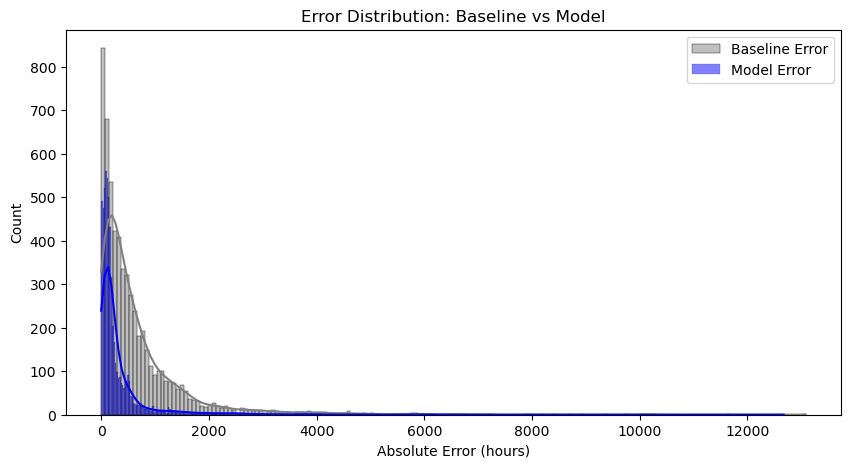

In [78]:
# Calculate absolute errors
result['baseline_error'] = abs(result['baseline_pred'] - result['total_resolution_hr'])
result['model_error'] = abs(result['model_pred'] - result['total_resolution_hr'])

# Calculate overall MAE and RMSE
mae_baseline = mean_absolute_error(result['total_resolution_hr'], result['baseline_pred'])
rmse_baseline = np.sqrt(mean_squared_error(result['total_resolution_hr'], result['baseline_pred']))

mae_model = mean_absolute_error(result['total_resolution_hr'], result['model_pred'])
rmse_model = np.sqrt(mean_squared_error(result['total_resolution_hr'], result['model_pred']))

print(f'Baseline\'s MAE and RMSE: {(mae_baseline, rmse_baseline)}')
print(f'Model\'s MAE and RMSE: {(mae_model, rmse_model)}')


# Plot
plt.figure(figsize=(10,5))
sns.histplot(result['baseline_error'], color='gray', label='Baseline Error', kde=True)
sns.histplot(result['model_error'], color='blue', label='Model Error', kde=True)
plt.xlabel('Absolute Error (hours)')
plt.title('Error Distribution: Baseline vs Model')
plt.legend()
plt.show()

#### 10.2 Comparing model and baseline errors by neighborhood

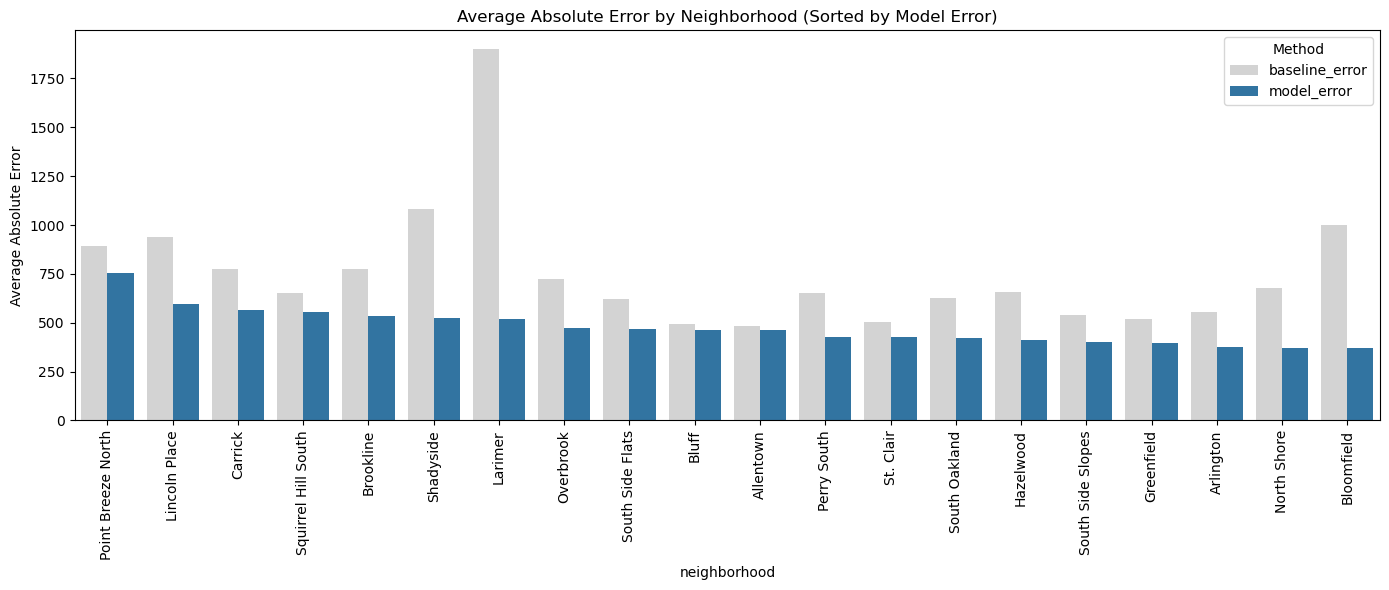

In [79]:
# Aggregate error by request_type_name request_type_name
grouped_errors = (
    result
    .groupby('neighborhood')[['baseline_error', 'model_error']]
    .mean()
    .reset_index()
)

# Rank the data by model's error
grouped_errors = grouped_errors.sort_values('model_error', ascending=False).head(20)

melted = grouped_errors.melt(
    id_vars='neighborhood',
    value_vars=['baseline_error', 'model_error'],
    var_name='Method',
    value_name='Average Absolute Error'
)

# Plotting bar chart
plt.figure(figsize=(14, 6))
sns.barplot(data=melted, x='neighborhood', y='Average Absolute Error', hue='Method', palette={'baseline_error': 'lightgray', 'model_error': '#1f77b4'})
plt.xticks(rotation=90)
plt.title('Average Absolute Error by Neighborhood (Sorted by Model Error)')
plt.tight_layout()
plt.show()


#### 10.3 Comparing model and baseline errors by neighborhood

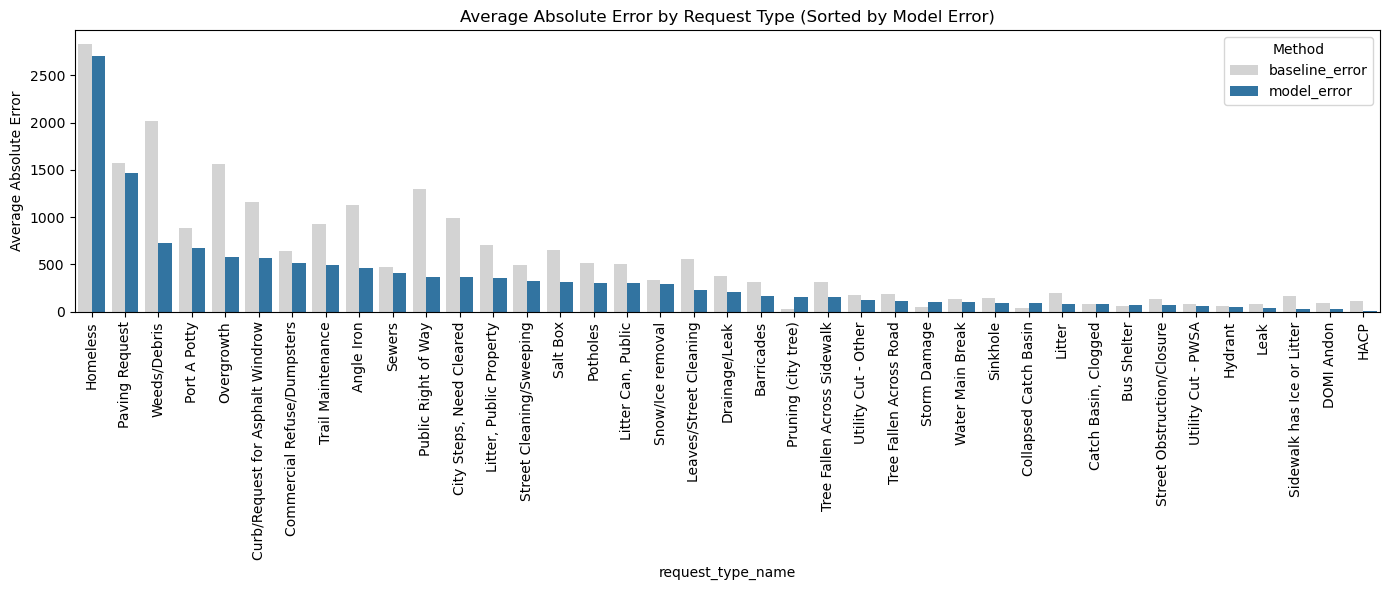

In [80]:
# Aggregate error by request_type_name request_type_name
grouped_errors = (
    result
    .groupby('request_type_name')[['baseline_error', 'model_error']]
    .mean()
    .reset_index()
)

# Rank the data by model's error
grouped_errors = grouped_errors.sort_values('model_error', ascending=False)

melted = grouped_errors.melt(
    id_vars='request_type_name',
    value_vars=['baseline_error', 'model_error'],
    var_name='Method',
    value_name='Average Absolute Error'
)

# Plotting bar chart
plt.figure(figsize=(14, 6))
sns.barplot(data=melted, x='request_type_name', y='Average Absolute Error', hue='Method', palette={'baseline_error': 'lightgray', 'model_error': '#1f77b4'})
plt.xticks(rotation=90)
plt.title('Average Absolute Error by Request Type (Sorted by Model Error)')
plt.tight_layout()
plt.show()


#### 10.4 Model errors over time

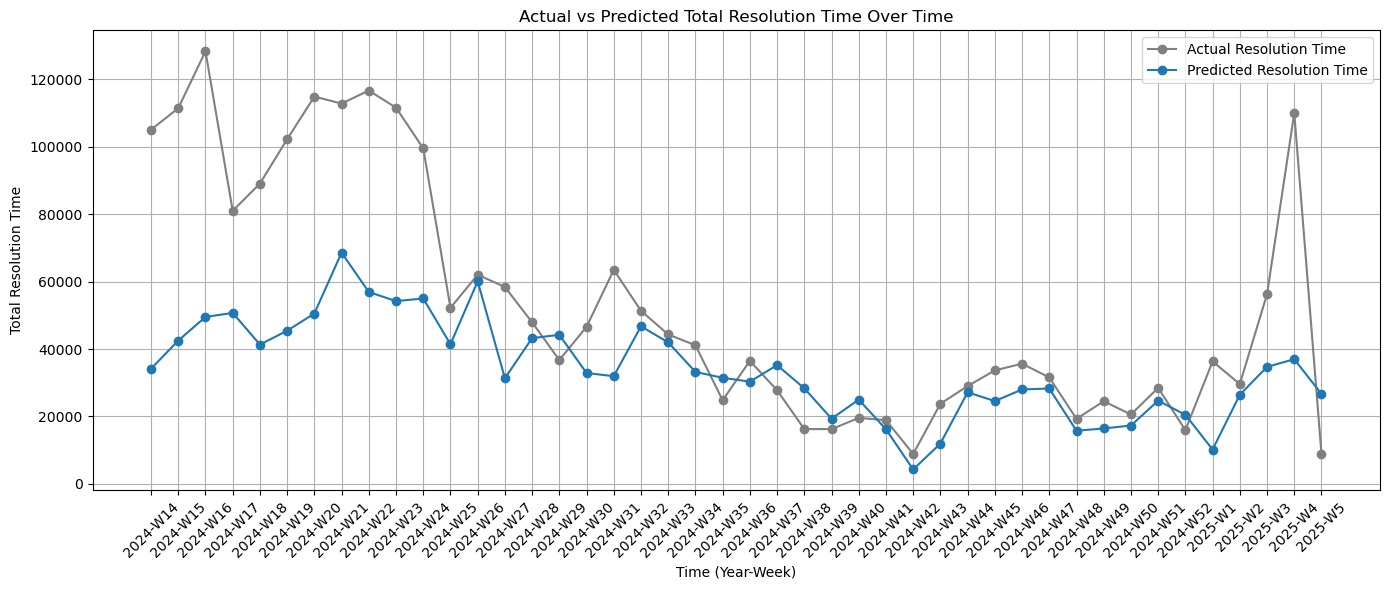

In [81]:
# Aggregate actual and predicted resolution times by year and week
time_series = (
    result
    .groupby(['year', 'week'])
    .agg(
        actual_resolution_time=('total_resolution_hr', 'sum'),
        predicted_resolution_time=('model_pred', 'sum')  # Replace with your column names
    )
    .reset_index()
)

# Create a "time" column for plotting (combining year and week)
time_series['time'] = time_series['year'].astype(str) + '-W' + time_series['week'].astype(str)

# Plotting the line graph
plt.figure(figsize=(14, 6))
plt.plot(time_series['time'], time_series['actual_resolution_time'], label='Actual Resolution Time', color='gray', marker='o')
plt.plot(time_series['time'], time_series['predicted_resolution_time'], label='Predicted Resolution Time', color='#1f77b4', marker='o')
plt.xlabel('Time (Year-Week)')
plt.ylabel('Total Resolution Time')
plt.title('Actual vs Predicted Total Resolution Time Over Time')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

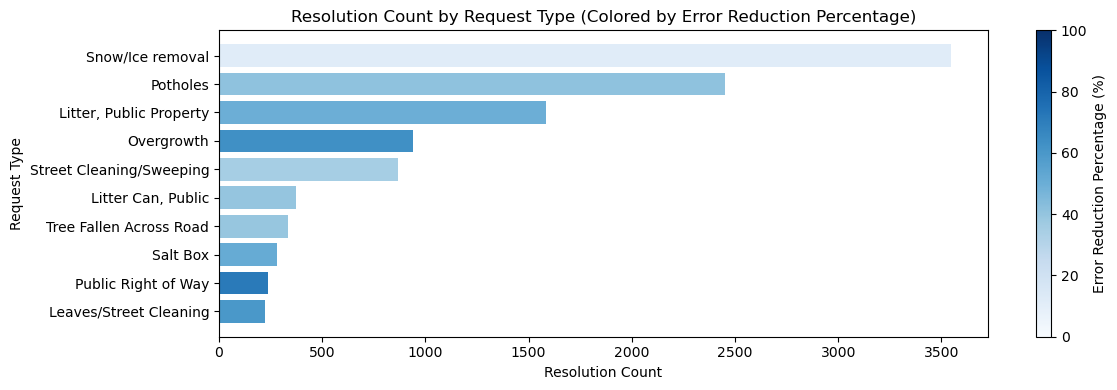

In [82]:
# Aggregate error and resolution count by request_type_name
grouped_errors = (
    result
    .groupby('request_type_name')
    .agg(
        baseline_error=('baseline_error', 'mean'),
        model_error=('model_error', 'mean'),
        resolution_count=('resolution_count', 'sum')  # Assuming 'resolution_count' column exists
    )
    .reset_index()
)

# Calculate the percentage reduction in model_error compared to baseline_error
grouped_errors['error_reduction_percentage'] = (
    (grouped_errors['baseline_error'] - grouped_errors['model_error']) / grouped_errors['baseline_error']
) * 100

# Sort by resolution count
grouped_errors = grouped_errors.sort_values('resolution_count', ascending=False).head(10)

# Normalize color based on error reduction percentage
norm = plt.Normalize(vmin=0, vmax=100)
colors = plt.cm.Blues(norm(grouped_errors['error_reduction_percentage']))

# Create figure and axes
fig, ax = plt.subplots(figsize=(12, 4))

# Bar chart
bars = ax.barh(
    grouped_errors['request_type_name'], 
    grouped_errors['resolution_count'], 
    color=colors
)

# Create a ScalarMappable and associate it with the current colormap and normalization
sm = plt.cm.ScalarMappable(cmap='Blues', norm=norm)
sm.set_array([])  # Required even if empty for colorbar

# Add colorbar and assign to correct axis
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label('Error Reduction Percentage (%)')

# Labels and styling
ax.set_xlabel('Resolution Count')
ax.set_ylabel('Request Type')
ax.set_title('Resolution Count by Request Type (Colored by Error Reduction Percentage)')
ax.invert_yaxis()  # Highest count at the top
plt.tight_layout()
plt.show()

In [83]:
# Make sure you pass the trained pipeline
result = permutation_importance(best_model, X_test, y_test, n_repeats=10, random_state=42)

# Display top features
importances_df = pd.DataFrame({
    'feature': X_test.columns,
    'importance_mean': result.importances_mean,
    'importance_std': result.importances_std
}).sort_values(by='importance_mean', ascending=False)

print(importances_df.head())


/opt/anaconda3/envs/s25_mlfinal/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/envs/s25_mlfinal/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/envs/s25_mlfinal/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/envs/s25_mlfinal/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/envs/s25_mlfi

                         feature  importance_mean  importance_std
0              request_type_name         0.044899        0.002702
4  last_week_total_resolution_hr         0.037564        0.001918
3     last_week_resolution_count         0.011189        0.001163
1                           week         0.009858        0.000808
2                   neighborhood         0.000234        0.000422


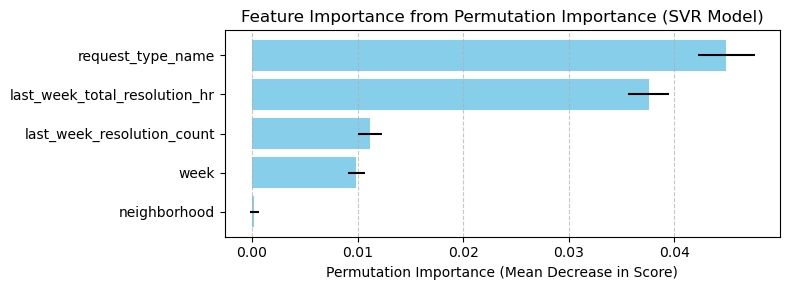

In [84]:
# Plot
plt.figure(figsize=(8, 3))
plt.barh(importances_df['feature'], importances_df['importance_mean'], xerr=importances_df['importance_std'], color='skyblue')
plt.xlabel('Permutation Importance (Mean Decrease in Score)')
plt.title('Feature Importance from Permutation Importance (SVR Model)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()